# Step 1: Generating spectrograms from audio files (and some cleaning)

This script creates spectrograms from a list of input audio files.

#### The following structure and files are required in the project directory:

    ├── audio
    │   ├── call_1.wav     <- call files 
    │   ├── call_2.wav     <- 
    │   ├── call_3.wav     <- 
    │   └── ...            <- 
    ├── data                  
    │   ├── info_file.csv  <- A ";"-separated csv file containing metadata about the calls
    │
    ├── parameters         
    ├── functions          <- the folder with the function files provided in the repo                
    ├── notebooks          <- the folder with the notebook files provided in the repo    
    ├── ...  
    

#### The following structure is required for info_file.csv:

info_file.csv must contain at least the two columns: "filename" and "label". If labels are completely unknown, there should still be a label column with some NA identifiers (e.g "NA", "unknown", ...)

    | filename   | label   | ...    |  .... 
    -----------------------------------------
    | call_1.wav | alarm   |  ...   |  ....   
    | call_2.wav | contact |  ...   |  ....  
    | ...        |  ...    |  ...   |  ....   

#### The following files are generated in this script:
    
    ├── data               
    │   ├── df.pkl          <- pickled pandas dataframe with metadata, raw_audio and spectrograms
    ├── parameters
    │   ├── spec_params.py  <- a .py file containing the spectrogramming parameters that were used
    ├── ...    

## Import statements, constants and functions

In [152]:
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path
import umap
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys 
print(os.getcwd())

sys.path.insert(0, '..')
%matplotlib inline

from functions.audio_functions import generate_mel_spectrogram, read_wavfile
from functions.preprocessing_functions import calc_zscore, pad_spectro


# Function for plotting example spectrograms
def plot_examples(df, random_indices, labels ,spec_type):
    if spec_type in df.columns:
    
        #df_subset = df.iloc[random_indices,:]

        #specs = df_subset[spec_type].values
        print(random_indices,labels)

        plt.figure(figsize=(len(random_indices)*3,3))
        for i,spec in enumerate(random_indices):
            print(i)
            plt.subplot(1, len(random_indices), i+1)
            plt.imshow((df.iloc[spec,:])[spec_type], origin='lower')
            plt.title(labels[i])
        plt.suptitle(spec_type)
        plt.tight_layout()
    else:
        print("Error: ",spec_type, " not in df columns")

/remote/idiap.svm/project.evolang/meerkats_imen/evolang_meerkats_calls_classification/workspace/mara-code/notebooks


In [ ]:
# Set important paths
P_DIR = str(Path(os.getcwd()).parents[0])            # project directory, by default set to parent directory
                                                     # of your current working directory
P_DIR = os.path.join("/idiap/project/evolang/meerkats_imen/dataset/isabel_data/")
AUDIO_IN = os.path.join(os.path.sep, P_DIR, 'audio') # --> audio directory, contains audio (.wav) files
AUDIO_IN = os.path.join(os.path.sep, P_DIR, 'processed_data/CutFilteredZeroCrossedCalls')
DATA = os.path.join(os.path.sep, P_DIR, 'data')      # --> empty data directory, output files will be put here


# Information about the info_file.csv
LABEL_COL = "labels"                                 # -->name of column that contains labels

NA_DESCRIPTORS = [0, np.nan, "NA", "na",            # Which values indicate that this vocalization is unlabelled?
                  "not available", "None",          # (add your NA descriptor if not yet in list)
                  "Unknown", "unknown", None, ""]        
                                                     
NEW_NA_INDICATOR = "unknown"                        # all vocalizations without label will be relabelled to
                                                    # "unkown"

# Other parameters
PLOT_EXAMPLES = True                                # Do you want to plot example spectrograms?

In [ ]:
# Check if directories are present

if not os.path.isdir(AUDIO_IN):
    print("No audio directory found")

if not os.path.isdir(DATA):
    os.mkdir(DATA)

# __*********************** NOTE  ***********************__

__By default, only mel-transformed, Decibel-transformed spectrograms are generated.__ 

If desired, you can __also create denoised spectrograms__ (bandpass-filtered to remove frequencies that likely only contain noise, or median subtracted to remove the effect of broadband impulse noise) __and time-stretched spectrograms__, e.g. stretch all spectrograms to the same duration. This may be helpful, if you do not wish to differentiate calls with the same shape, but different duration.

Set the variables BANDPASS_FILTER, MEDIAN_SUB or STRETCH to "True" to create these additional, alternative spectrograms. You can also combine these preprocessing steps in any possible way (e.g. create bandpass-filtered, median-subtracted spectrograms) or add your own preprocessing steps.

In [ ]:
BANDPASS_FILTER = True  # should bandpass-filtered spectrograms be generated?
MEDIAN_SUB = True # should median-subtracted spectrograms be generated (reduce impulse noise)?
STRETCH = True   # should time-stretched spectrograms be generated (all stretched to max. duration in dataset)?

## 1. Read in files

In [ ]:
info_file = os.path.join(os.path.sep, P_DIR, 'info_file.csv')

if os.path.isfile(info_file):
    #df = pd.read_csv(info_file, sep=";", index_col=[0])
    df = pd.read_csv(info_file, sep=",")
else:
    print("Input file missing: ", info_file)
    print("Will create default input file without labels")
    audiofiles = os.listdir(AUDIO_IN)
    if len(audiofiles)>0:
        df = pd.DataFrame({'filename': [os.path.basename(x) for x in audiofiles], 'label': ["unknown"] * len(audiofiles)})

In [ ]:
df["labels"]

#### Check if all audio files are in AUDIO_IN directory

In [ ]:
audiofiles = [ x.split("/")[-1] for x in df['path'].values ]     
files_in_audio_directory = os.listdir(AUDIO_IN)

# Are there any files that are in the info_file.csv, but not in AUDIO_IN?
missing_files = list(set(audiofiles) - set(files_in_audio_directory))
if len(missing_files)>0:
    print("Warning: ", len(missing_files), "files with no matching audio in audio folder") 
    #print(missing)

In [ ]:
audio_filepaths = [os.path.join(os.path.sep, AUDIO_IN,x) for x in audiofiles]


## 2. Adding audio (and samplerate) to dataframe

In [ ]:
raw_audio,samplerate_hz = map(list,zip(*[read_wavfile(x) for x in audio_filepaths]))
df['raw_audio'] = raw_audio
df['samplerate_hz'] = samplerate_hz


In [ ]:
# Removing NA rows

nrows = df.shape[0]
df.dropna(subset=['raw_audio'], inplace=True)
print("Dropped ", nrows-df.shape[0], " rows due to missing/failed audio")

## 3. Removing very long calls

It's advisable to remove very long calls, as all calls will be zero-padded to the maximum duration in the dataset.

In [ ]:
# Extract duration of calls
df['duration_s'] = [x.shape[0] for x in df['raw_audio']]/df['samplerate_hz']

In [ ]:
# It can be helpful to plot the distribution to find a good cutoff

n, bins, patches = plt.hist(df['duration_s'])

In our case, dataset was already cleaned and all calls were between 0-0.5s, so no need to remove long calls. Set MIN_DUR and MAX_DUR to values that make sense for your dataset.

In [ ]:
MIN_DUR = 0  # --> minimum duration of calls in seconds
MAX_DUR = 0.8 # --> maximum duration of calls in seconds

In [ ]:
print("Dropped ", df.loc[df['duration_s']<MIN_DUR,:].shape[0], "rows below ", MIN_DUR, "s (min_dur)")
df = df.loc[df['duration_s']>=MIN_DUR,:]
print("Dropped ", df.loc[df['duration_s']>MAX_DUR,:].shape[0], "rows above ", MAX_DUR, "s (max_dur)")
df = df.loc[df['duration_s']<=MAX_DUR,:]

## 4. Generate mel-spectrograms

In this step, spectrograms are generated from audio files via short-time fourier transformation. Spectrograms capture the frequency components of a signal over time. A spectrogram is a 2D matrix, where each value represents the signal intensity in a specific time (columns) and frequency bin (row). In this case, the frequency axis of the spectrograms are also Mel-transformed (a logarithmic scale) and signal intensity is expressed on a Decibel scale.

### 4.1. Set spectrogramming parameters

The following parameters define how the spectrograms are computed. These are default values which are appropriate for the meerkat dataset, but should be adapted for other datasets.

In [153]:
N_MELS = 40 # --> number of mel bins (usually 20-40)
            # The frequency bins are transformed to this number of logarithmically spaced mel bins.

FFT_WIN = 0.015 # --> length of audio chunk when applying STFT in seconds
                   # FFT_WIN * samplerate = number of audio datapoints that go in one fft (=n_fft)

FFT_HOP = 0.005 # --> hop_length in seconds
                        # FFT_HOP * samplerate = n of audio datapoints between successive ffts (=hop_length)

WINDOW = 'hann' # --> name of window function
                    # each frame of audio is windowed by a window function. We use the window function 'hanning',  

FMIN = 0 # --> lower bound for frequency (in Hz) when generating Mel filterbank

FMAX = int(np.min(df['samplerate_hz'])/2) #--> upper bound for frequency (in Hz) when generating Mel filterbank
                                                     # this is set to 0.5 times the samplerate (-> Nyquist rule)
                                                     # If input files have different samplerates, the lowest samplerate is used
                                                     # to ensure all spectrograms have the same frequency resolution.

### 4.2. Save spectrogramming parameters

Save the parameters that were used, as they will be accessed later to label the frequeny and time axes of spectrogram images correctly.

In [154]:
if not os.path.isdir(os.path.join(os.path.sep, P_DIR, 'parameters')):
    os.mkdir(os.path.join(os.path.sep, P_DIR, 'parameters'))

spec_params_file = os.path.join(os.path.sep, P_DIR, 'parameters','spec_params.py')

lines = ['N_MELS = '+str(N_MELS),
         'FFT_WIN = '+str(FFT_WIN),
         'FFT_HOP = '+str(FFT_HOP),
         'WINDOW = "'+str(WINDOW)+'"',
         'FMIN = '+str(FMIN),'FMAX = '+str(FMAX)]
    
with open(spec_params_file, 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

### 4.3. Generate spectrograms

This code produces mel-transformed spectrograms on Decibel scale.

In [155]:
spectrograms = df.apply(lambda row: generate_mel_spectrogram(data = row['raw_audio'],
                                                             rate = row['samplerate_hz'],
                                                             n_mels = N_MELS,
                                                             window = WINDOW,
                                                             fft_win = FFT_WIN,
                                                             fft_hop = FFT_HOP,
                                                             fmax = FMAX), 
                               axis=1)


df['spectrograms'] = spectrograms

In [156]:
# Removing NA rows

nrows = df.shape[0]
df.dropna(subset=['spectrograms'], inplace=True)
print("Dropped ", nrows-df.shape[0], " rows due to failed spectrogram generation")

Dropped  0  rows due to failed spectrogram generation


#### Show example spectrograms
Plot some example spectrograms as a sanity-check, to see if they are reasonable

In [157]:
# Randomly choose some example vocalizations

n_examples = 5
random_indices = [random.randint(0,df.shape[0]) for x in [0]*n_examples]

In [158]:
indices=[]
label=[]
while len(indices) < 6:
    ind=random.randrange(0,2181,1)
    if df.iloc[ind].labels not in label:
        label.append(df.iloc[ind].labels)
        indices.append(ind)
        print(ind)


238
1611
177
1927
1160
1271


[238, 1611, 177, 1927, 1160, 1271] ['FO', 'EA', 'SC', 'PV', 'MO', 'DI']
0
1
2
3
4
5


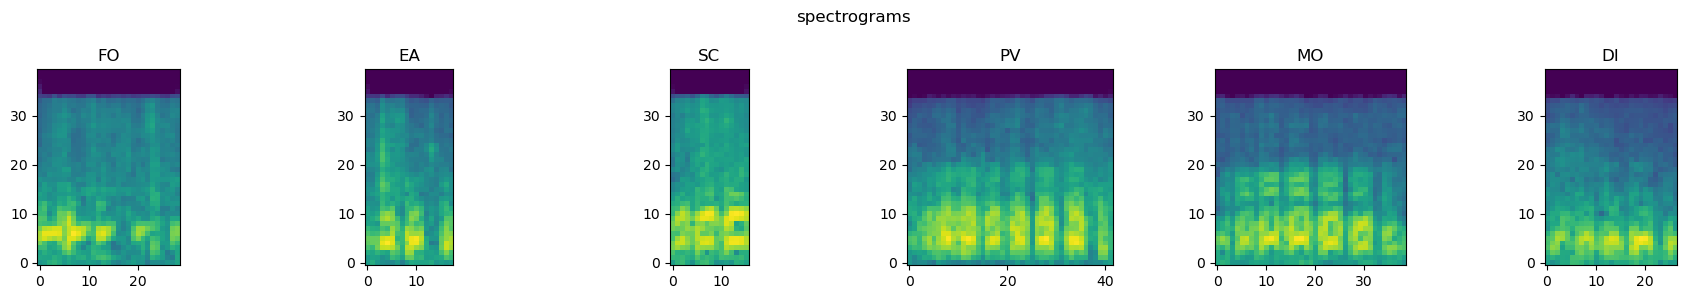

AttributeError: module 'matplotlib' has no attribute 'pyplot'

In [159]:
if PLOT_EXAMPLES: plot_examples(df, indices, label, 'spectrograms')

## [Optional:  Generate denoised spectrograms (median subtraction):]

Generate denoised spectrograms (denoised by median subtraction to reduce impulse noise) to have them available as an alternative input to UMAP:

In [ ]:
if MEDIAN_SUB:
    df['denoised_spectrograms'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['spectrograms']]

In [ ]:
if MEDIAN_SUB and PLOT_EXAMPLES: plot_examples(df, indices,label, 'denoised_spectrograms')

## [Optional : Generate denoised spectrograms (bandpass filter):]

Generate denoised spectrograms (denoised with a bandpass filter to reduce noise) to have them available as an alternative input to UMAP:

__Note that FMIN and FMAX are then set to LOWCUT and HIGHCUT when generating the spectrograms (as all frequency intervals below or above will be empty)__

In [ ]:
LOWCUT = 300.0              # lower bound in Hz (all signals below this bound will be removed)  
HIGHCUT = 3000.0            # upper bound in Hz (all signals above this bound will be removed)
N_MELS_FILTERED = N_MELS    # N_Mels. Depending on your cutoffs, it may make sense to adapt these, too! 

In [ ]:
if BANDPASS_FILTER:   
    
    # update spec_params
    lines = ['N_MELS = '+str(N_MELS),
             'FFT_WIN = '+str(FFT_WIN),
             'FFT_HOP = '+str(FFT_HOP),
             'WINDOW = "'+str(WINDOW)+'"',
             'FMIN = '+str(FMIN),
             'FMAX = '+str(FMAX),
             'LOWCUT = '+str(LOWCUT),
             'HIGHCUT = '+str(HIGHCUT),
             'N_MELS_FILTERED = '+str(N_MELS_FILTERED)]

    with open(os.path.join(os.path.sep, P_DIR, 'parameters','spec_params.py'), 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

In [ ]:
if BANDPASS_FILTER:
    from functions.audio_functions import butter_bandpass_filter
    
    
    # create filtered audio
    df['filtered_audio'] = df.apply(lambda row: butter_bandpass_filter(data = row['raw_audio'],
                                                                       lowcut = LOWCUT,
                                                                       highcut = HIGHCUT,
                                                                       sr = row['samplerate_hz'],
                                                                       order = 6),
                               axis=1)

    # create spectrograms from filtered audio      
    df['filtered_spectrograms'] = df.apply(lambda row: generate_mel_spectrogram(data = row['filtered_audio'],
                                                                                rate = row['samplerate_hz'],
                                                                                n_mels = N_MELS_FILTERED,
                                                                                window = WINDOW,
                                                                                fft_win = FFT_WIN,
                                                                                fft_hop = FFT_HOP,
                                                                                fmax = HIGHCUT,
                                                                                fmin = LOWCUT
                                                                               ), 
                                           axis=1)

In [ ]:
if BANDPASS_FILTER and PLOT_EXAMPLES: plot_examples(df, indices, label,'filtered_spectrograms')

## [Optional:  Generate stretched spectrograms (all stretched to equal length)]

Stretch all calls to equal length, e.g. maximum length in the dataset (using phase vocoder algorithm) and generate spectrograms from these stretched calls.

In [ ]:
if STRETCH:
    from functions.audio_functions import generate_stretched_mel_spectrogram
    
    MAX_DURATION = np.max(df['duration_s'])

    df['stretched_spectrograms'] = df.apply(lambda row: generate_stretched_mel_spectrogram(row['raw_audio'],
                                                                                           row['samplerate_hz'],
                                                                                           row['duration_s'],
                                                                                           N_MELS,
                                                                                           WINDOW,
                                                                                           FFT_WIN,
                                                                                           FFT_HOP,
                                                                                           MAX_DURATION),
                                            axis=1)

In [ ]:
if STRETCH and PLOT_EXAMPLES: plot_examples(df, indices,label, 'stretched_spectrograms')

## [Optional: Create any combination of preprocessing steps]

It is also possible to combine different preprocessing steps. For example, I could apply median subtraction to the bandpass-filtered spectrograms:

In [ ]:
if 'filtered_spectrograms' in df.columns:
    df['denoised_filtered_spectrograms'] = [(spectrogram - np.median(spectrogram, axis=0)) for spectrogram in df['filtered_spectrograms']]

In [ ]:
plot_examples(df, indices,label, 'denoised_filtered_spectrograms')


## 5. Clean labels

Make sure that all labels are strings and vocalizations with missing labels are labelled as "unknown"

In [ ]:
df['original_label'] = df[LABEL_COL] #  original labels are saved in "original_label" column

df['label'] = ["unknown" if x in NA_DESCRIPTORS else x for x in df[LABEL_COL]]  # "unknown" for all NA labels
labels = df['label'].fillna(NEW_NA_INDICATOR) # double-check
df['label'] = labels.astype(str) # transform to strings and save in df as "label" column

## 6. Save dataframe

In [ ]:
df.to_pickle(os.path.join(os.path.sep, DATA, 'df.pkl'))